In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/氧化铝周度表需non_trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['氧化铝周度表需/4WMANon-Trend/F0.2'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,氧化铝周度表需/4WMANon-Trend/F0.2,动力煤日耗/25省,氧化铝进口盈亏,中国氧化铝周度进口（Kpler）/4WMA,电解铝加权利润,氧化铝电解铝厂原料库存4周环比,中国氧化铝周度出口（Kpler）/8WMA,氧化铝期货收盘价60日环比
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['氧化铝周度表需/4WMANon-Trend/F0.2', '动力煤日耗/25省', '氧化铝进口盈亏',
       '中国氧化铝周度进口（Kpler）/4WMA', '电解铝加权利润', '氧化铝电解铝厂原料库存4周环比',
       '中国氧化铝周度出口（Kpler）/8WMA', '氧化铝期货收盘价60日环比'],
      dtype='object')

In [6]:
################################# 处理缺失值 #################################
fill_methods = {
'动力煤日耗/25省': 'interpolate', 
'氧化铝进口盈亏': 'interpolate',
'中国氧化铝周度进口（Kpler）/4WMA': 'interpolate', 
'电解铝加权利润': 'interpolate', 
'氧化铝电解铝厂原料库存4周环比': 'interpolate',
'中国氧化铝周度出口（Kpler）/8WMA': 'interpolate', 
'氧化铝期货收盘价60日环比': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet = sheet.resample('W-FRI').mean()
#sheet.loc[:last_day, '氧化铝周度表需/4WMANon-Trend/F0.2'] = sheet.loc[:last_day, '氧化铝周度表需/4WMANon-Trend/F0.2'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['氧化铝电解铝厂原料库存4周环比_提前5周'] = sheet['氧化铝电解铝厂原料库存4周环比'].shift(5)
sheet['动力煤日耗/25省_提前9周'] = sheet['动力煤日耗/25省'].shift(9)
sheet['氧化铝进口盈亏_提前4周'] = sheet['氧化铝进口盈亏'].shift(4)
sheet['中国氧化铝周度进口（Kpler）/4WMA_提前4周'] = sheet['中国氧化铝周度进口（Kpler）/4WMA'].shift(4)
sheet['电解铝加权利润_提前4周'] = sheet['电解铝加权利润'].shift(4)
sheet['氧化铝期货收盘价60日环比_提前5周'] = sheet['氧化铝期货收盘价60日环比'].shift(5)

sheet['氧化铝进口盈亏_提前4周_逆序'] = reverse_column(sheet, '氧化铝进口盈亏_提前4周')
sheet['中国氧化铝周度进口（Kpler）/4WMA_提前4周_逆序'] = reverse_column(sheet, '中国氧化铝周度进口（Kpler）/4WMA_提前4周')
sheet['氧化铝期货收盘价60日环比_提前5周_逆序'] = reverse_column(sheet, '氧化铝期货收盘价60日环比_提前5周')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['氧化铝周度表需/4WMANon-Trend/F0.2'].notna())
]

################################# 数据 读取-处理 结束 #################################

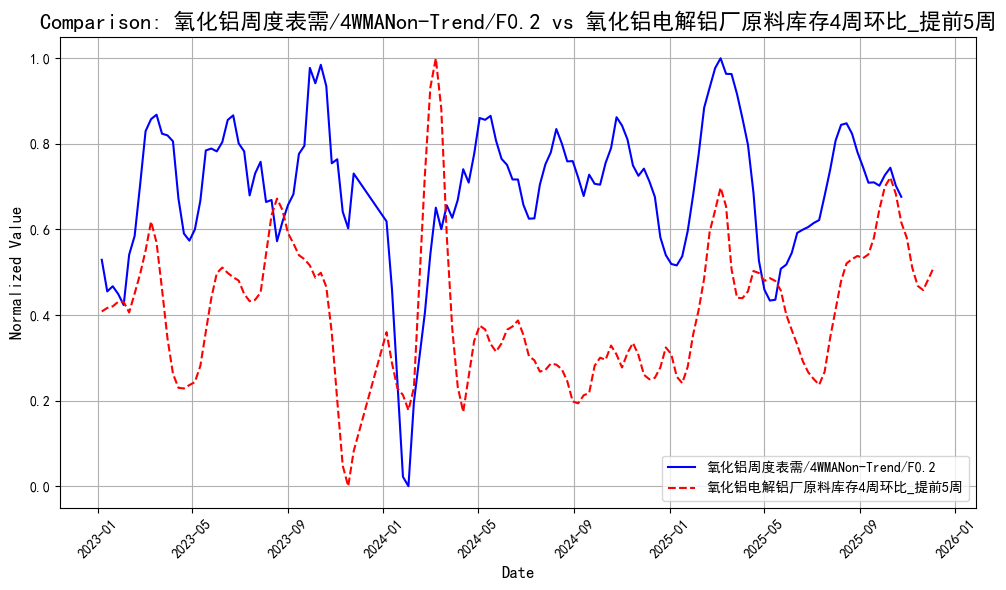

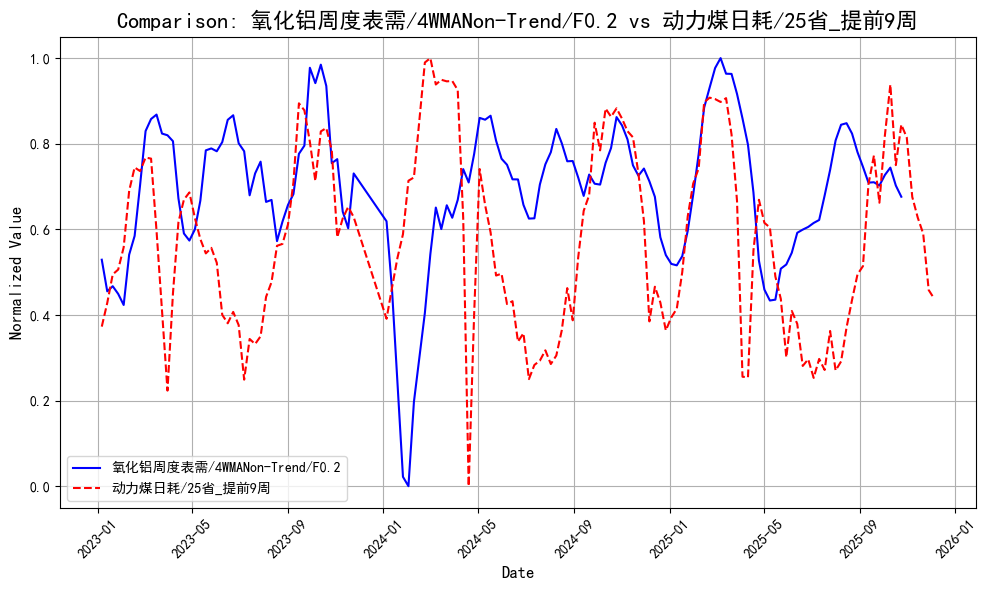

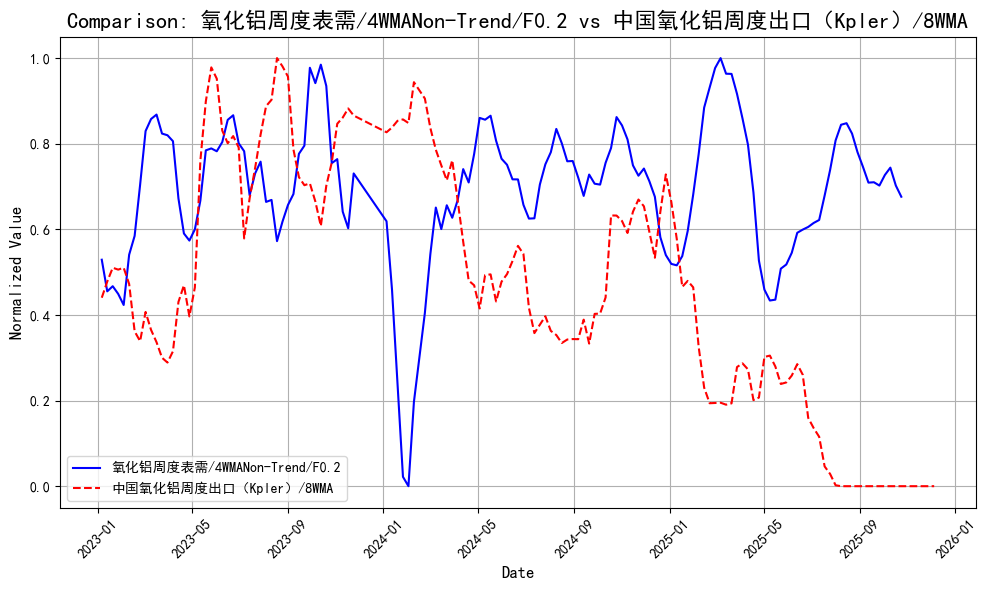

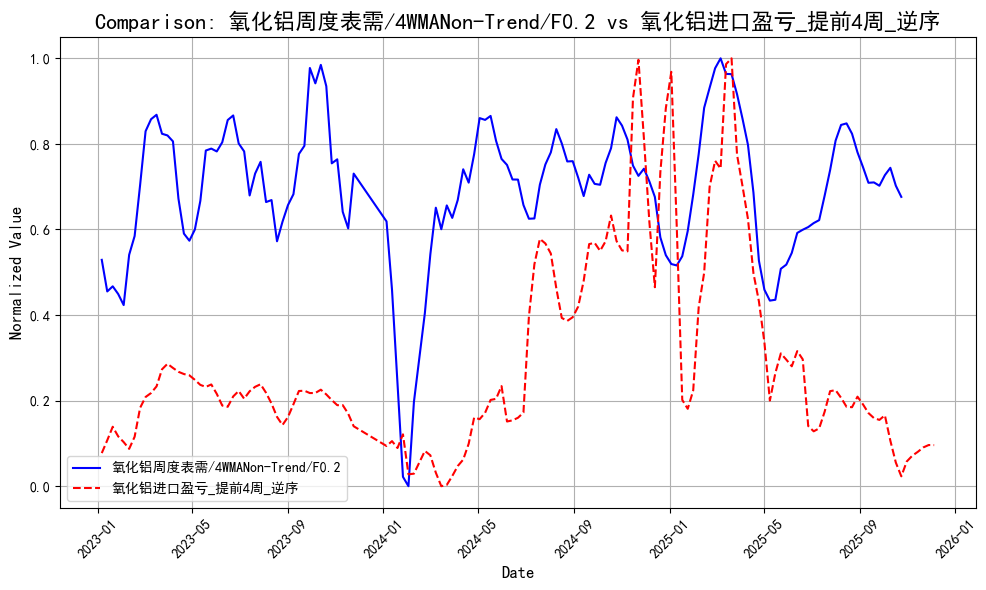

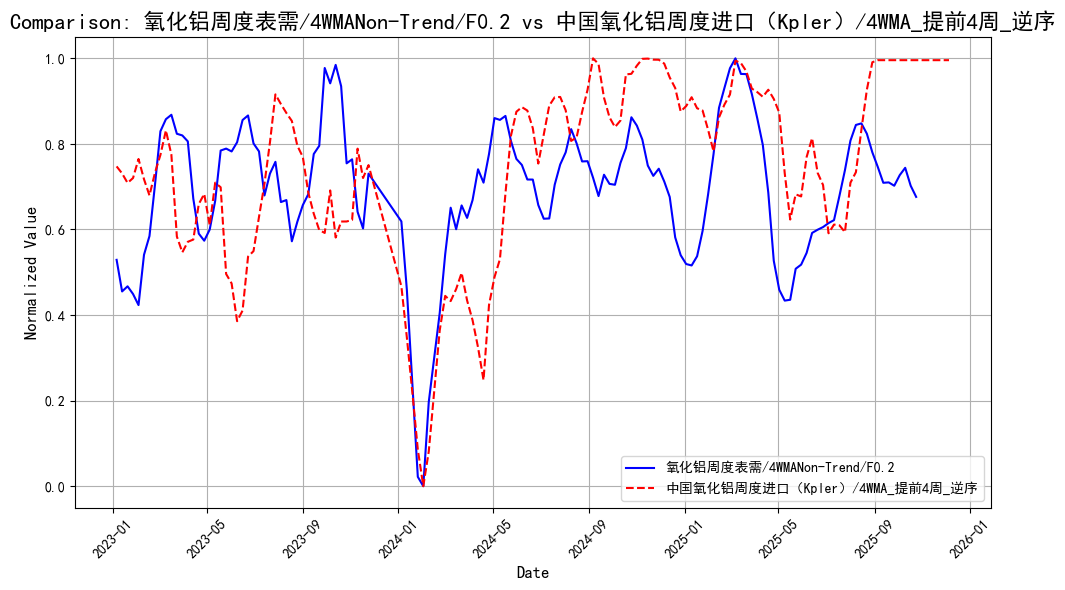

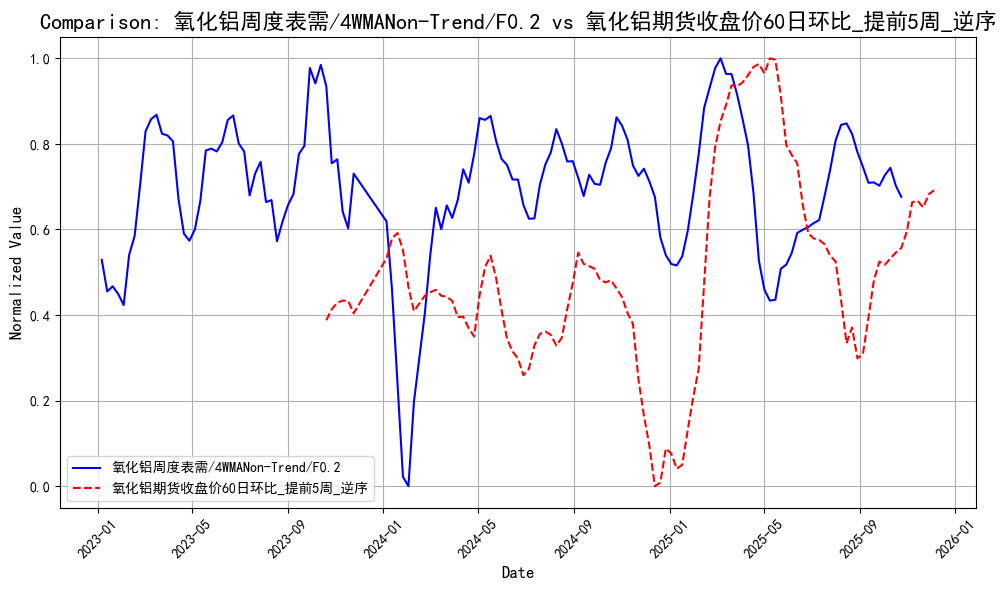

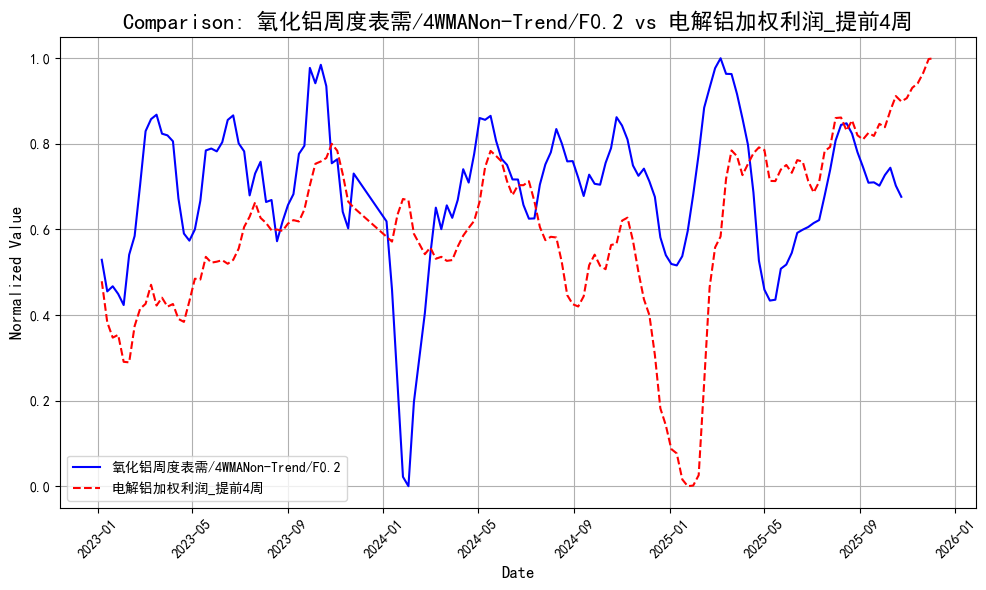

In [7]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='氧化铝周度表需/4WMANon-Trend/F0.2', 
    compare_cols=[
        '氧化铝电解铝厂原料库存4周环比_提前5周',
        '动力煤日耗/25省_提前9周',
        '中国氧化铝周度出口（Kpler）/8WMA',
        '氧化铝进口盈亏_提前4周_逆序',
        '中国氧化铝周度进口（Kpler）/4WMA_提前4周_逆序',
        '氧化铝期货收盘价60日环比_提前5周_逆序',
        '电解铝加权利润_提前4周'
        ]
)

In [8]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 4
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '氧化铝电解铝厂原料库存4周环比_提前5周',
        '动力煤日耗/25省_提前9周',
        '中国氧化铝周度出口（Kpler）/8WMA',
        '氧化铝进口盈亏_提前4周_逆序',
        '中国氧化铝周度进口（Kpler）/4WMA_提前4周_逆序',
        '氧化铝期货收盘价60日环比_提前5周_逆序',
        '电解铝加权利润_提前4周'
]

predict_column = '氧化铝周度表需/4WMANon-Trend/F0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

'''
# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)
'''

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.05,  # 学习率
    'max_depth': 4,  # 树深度
    'min_child_weight': 7,  # 最小子节点权重
    'subsample': 0.9,  # 样本采样比例
    'colsample_bytree': 0.7,  # 特征采样比例
    'gamma': 0.05,  # 分裂阈值
    'reg_alpha': 0.3,  # L1正则化
    'reg_lambda': 1.5,  # L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
    'tree_method': 'auto'
}


num_boost_round = 500
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.67346	train-rmse:3.44092


[499]	eval-rmse:2.44046	train-rmse:0.34369


训练集 MSE (DMatrix): 0.2076, 训练集 R² (DMatrix): 0.9868
测试集 MSE (DMatrix): 5.9558, 测试集 R² (DMatrix): -15.0261


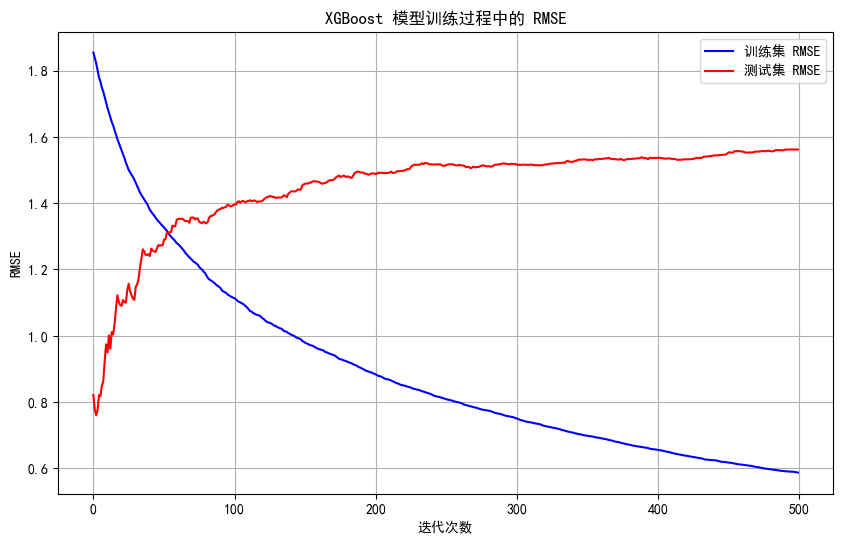

In [9]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:3.38961


[499]	train-rmse:0.36806


全部数据 MSE: 0.2443, 全部数据 R²: 0.9841


Gap between last actual value and first prediction: 0.07513215675354012


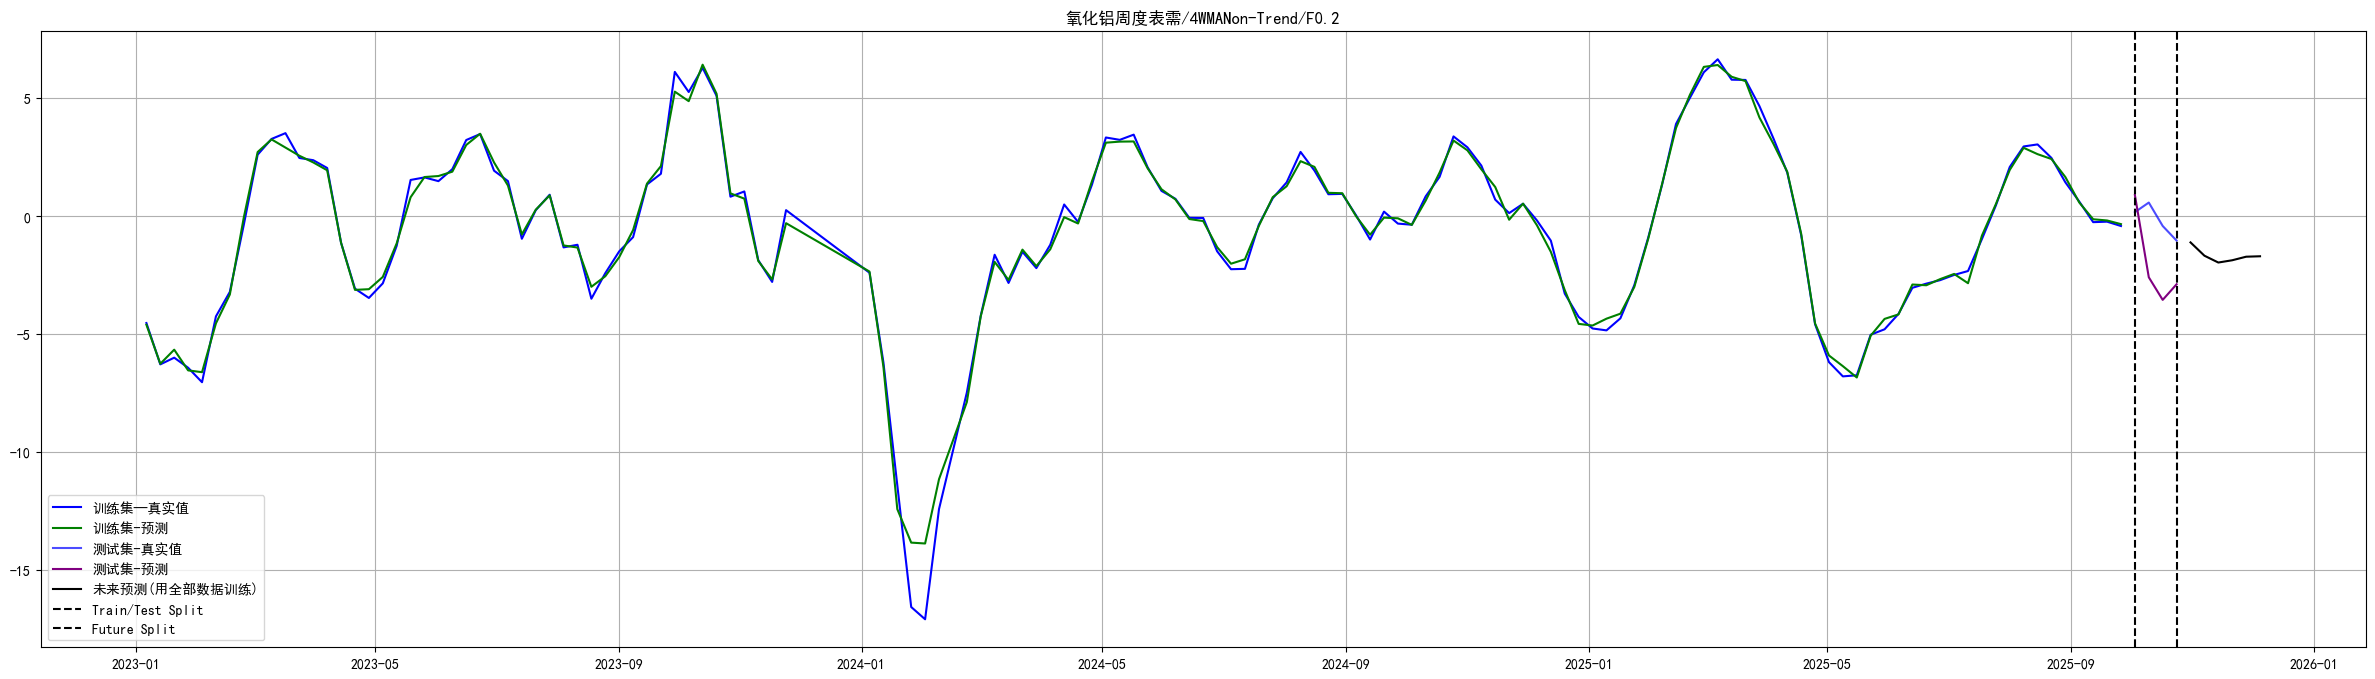

In [11]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
#plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('氧化铝周度表需/4WMANon-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()

---

In [12]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/氧化铝周度表需Non-Trend_F0.2_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
146,2025/12/05,NaN,-1.704642
145,2025/11/28,NaN,-1.723193
144,2025/11/21,NaN,-1.873844
143,2025/11/14,NaN,-1.970340
142,2025/11/07,NaN,-1.680814
...,...,...,...
4,2023/02/03,-7.0473,NaN
3,2023/01/27,-6.4338,NaN
2,2023/01/20,-6.0062,NaN
1,2023/01/13,-6.2902,NaN


In [13]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/氧化铝周度表需Non-Trend_F0.2_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
35,2025/12/31,NaN,-1.704642
34,2025/11/30,NaN,-1.812048
33,2025/10/31,-0.180600,-1.853404
32,2025/09/30,-0.075050,-0.021901
31,2025/08/31,2.394540,2.311267
30,2025/07/31,-1.338575,-1.406489
29,2025/06/30,-3.193525,-3.170348
28,2025/05/31,-5.916140,-5.711652
27,2025/04/30,-0.060425,-0.087754
26,2025/03/31,5.719025,5.555781


In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "氧化铝周度表需/4WMANon-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "详情页"
identifier = "氧化铝周度表需/4WMANon-Trend/F0.2"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
